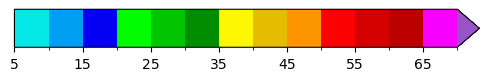

In [8]:
import os, glob
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from wrf import (getvar, to_np, smooth2d, get_cartopy, cartopy_xlim,interplevel,
                 cartopy_ylim, latlon_coords, CoordPair, vertcross, ll_to_xy)
from netCDF4 import Dataset

import cartopy.crs as crs
import cartopy.feature as cfeat 
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from cartopy.io.shapereader import Reader
#from cartopy.feature import NaturalEarthFeature

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors, BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from plt_refs import plt_rf

SHP = r'/share/home/zhaokun/.local/share/cartopy/shapefiles/natural_earth/china_shp'

def show_cmap(cmap, norm=None, extend=None):
    '''展示一个colormap.'''
    if norm is None:
        norm = mcolors.Normalize(vmin=0, vmax=cmap.N)
    im = cm.ScalarMappable(norm=norm, cmap=cmap)

    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    fig.colorbar(im, cax=ax, orientation='horizontal', extend=extend)
    plt.show()

dbz_levels = np.arange(5., 75., 5.)     
# Create the color table found on NWS pages.
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0
dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")
show_cmap(dbz_map, dbz_norm)

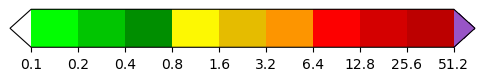

In [9]:
prcp_levels = [0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2]
prcp_rgb = np.array([ [255,255,255],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],
                    [152,84,198]], np.float32) / 255.0

prcp_map, prcp_norm = from_levels_and_colors(prcp_levels, prcp_rgb,
                                           extend="both")
show_cmap(prcp_map, prcp_norm)

组合多个试验，多个时刻的子图

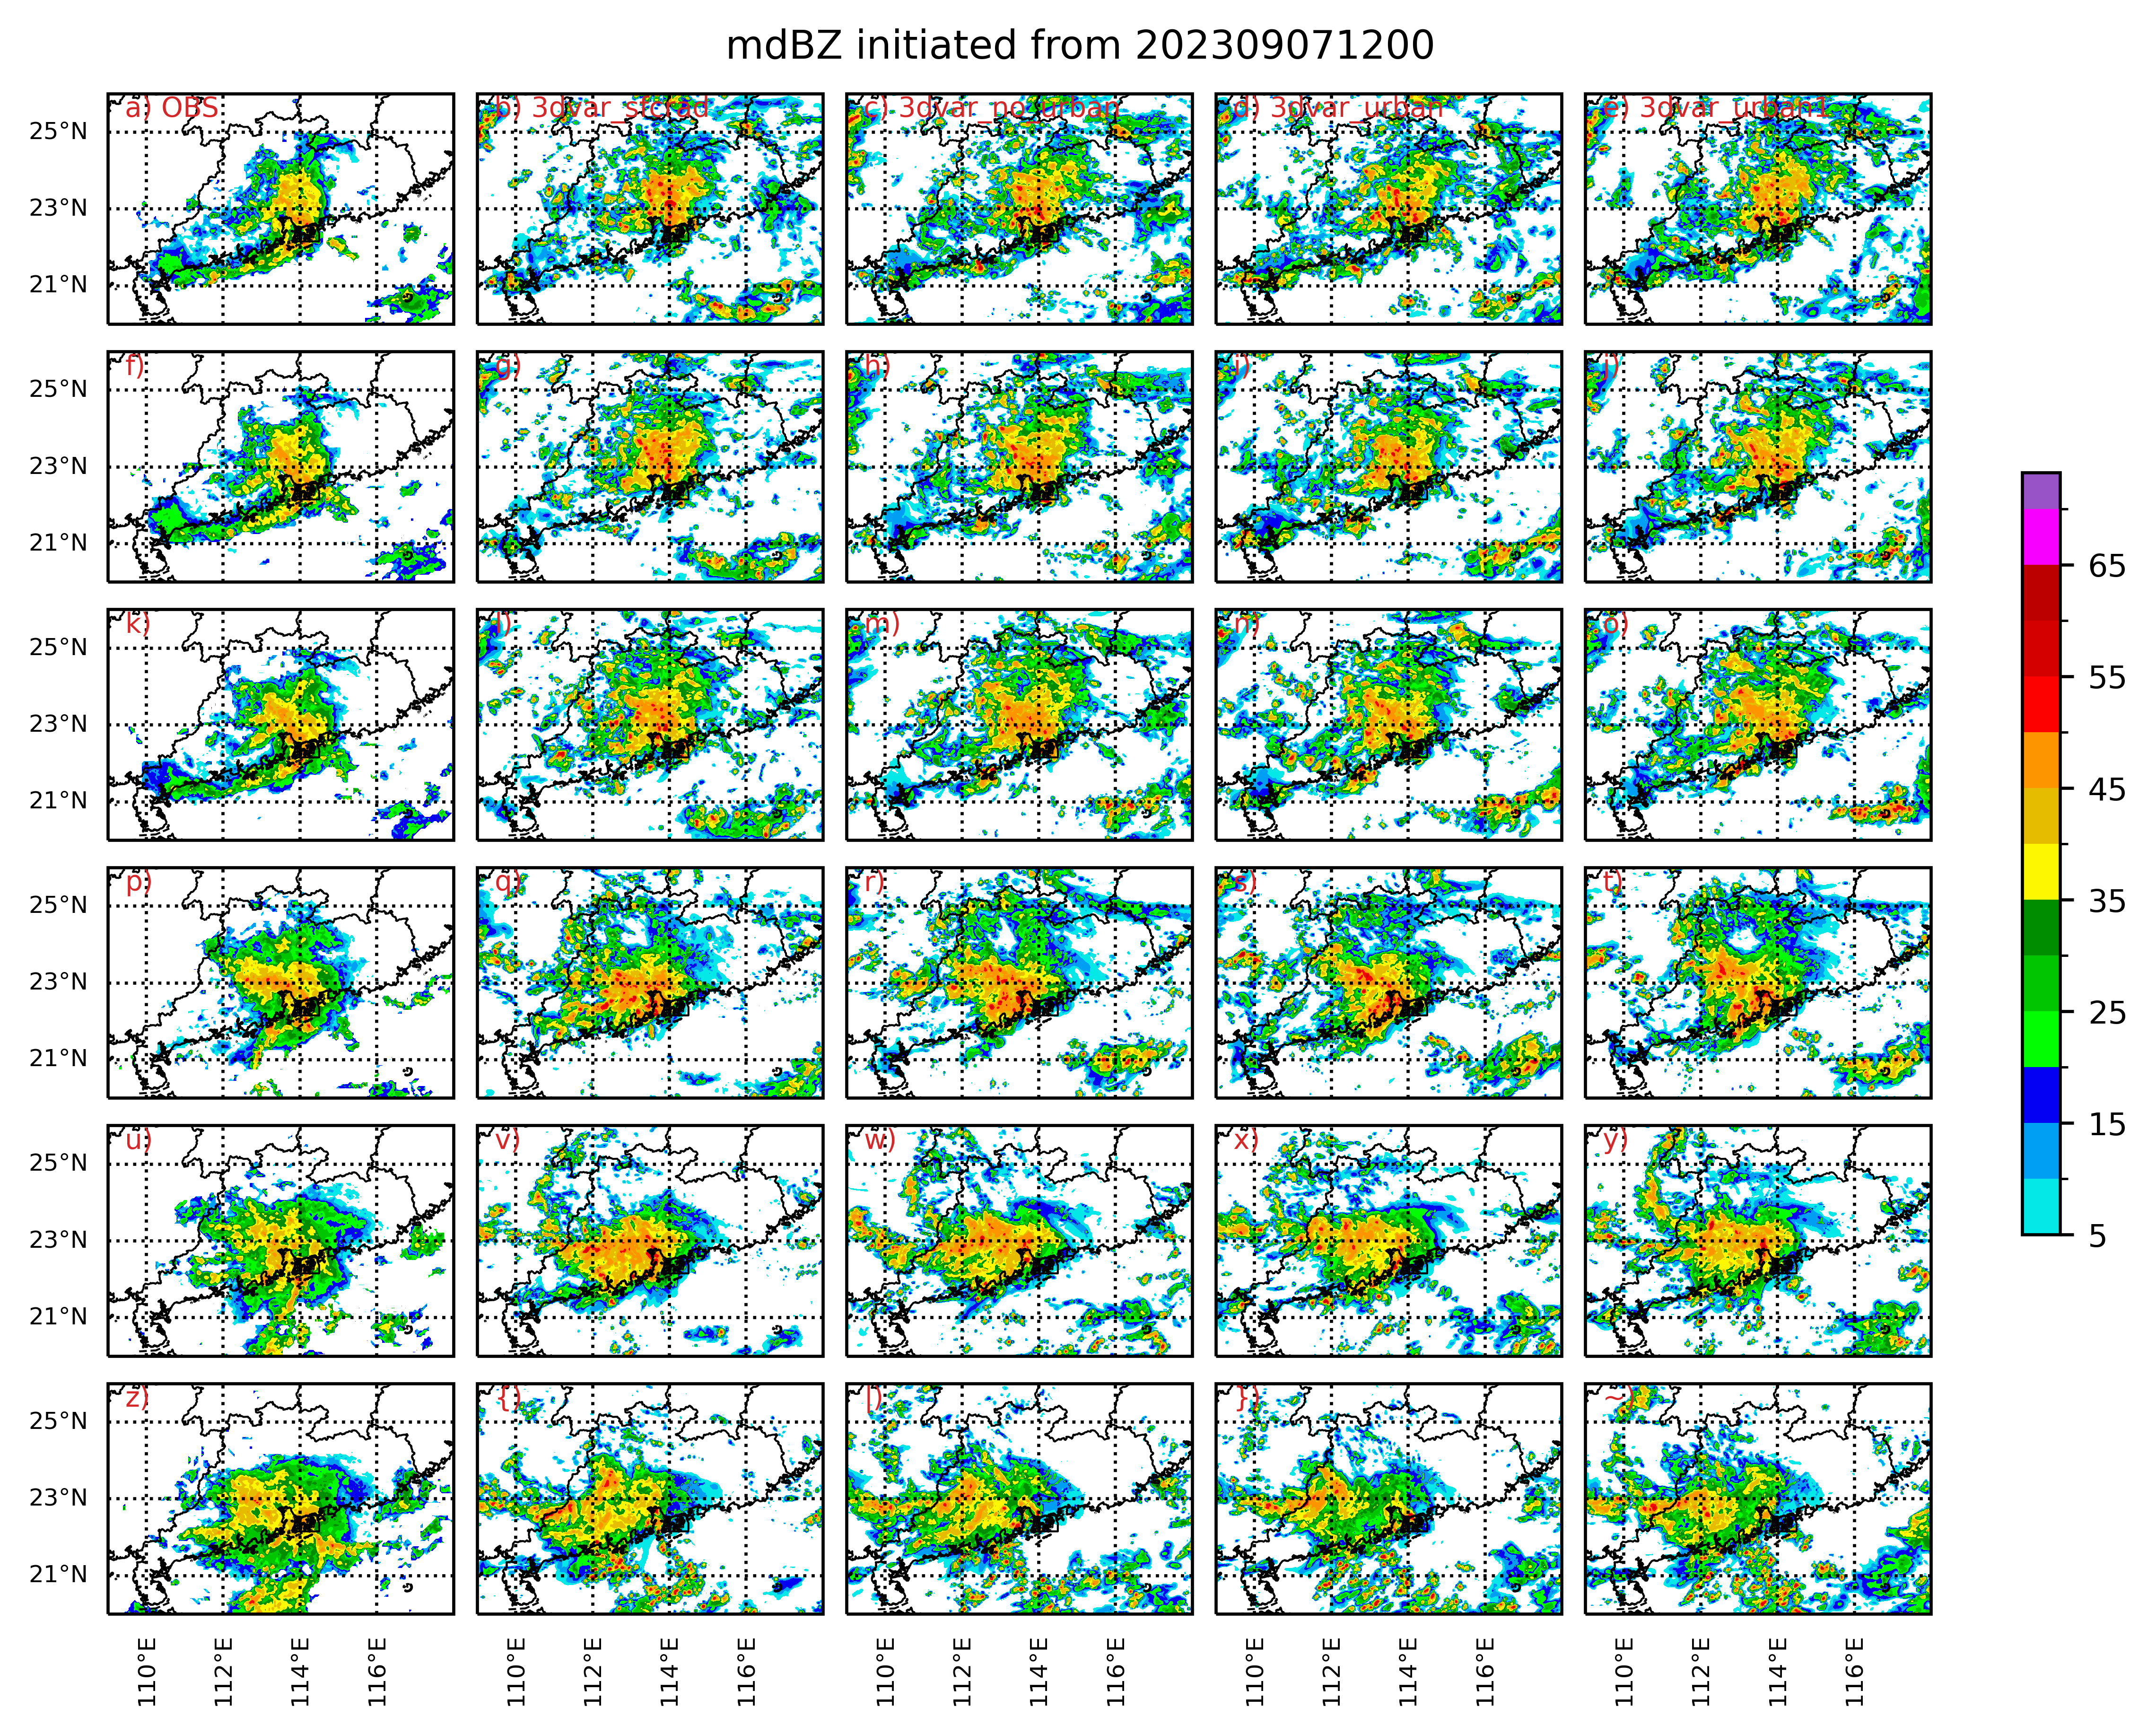

In [10]:
exp_names = ['OBS', '3dvar_sfcrad','3dvar_no_urban','3dvar_urban','3dvar_urban1'] #'radar_1h_cv7', 'hybrid_radar_1h','hybrid_noVinEnkf']
#fcst_hrs = [1, 2, 3, 4, 5, 6]
fcst_hrs = [1,2,3,6,9,12]
#fcst_hrs = [1, 3, 6, 12, 18, 24]

cur_date = datetime(2023,9,7,12,0)
end_date = datetime(2023,9,7,12,0)
extend = [109.,118.0,20.,26.]

OBS_dir = '/share/home/zhaokun/haiqin/data/radar1hr/202309'
pathin = '/share/home/zhaokun/scratch/haiqin/exp/Haikui/'
pathout = '/share/home/zhaokun/haiqin/scripts/plot/saola_mdbz'

file_pattern = 'wrfout_d02_'

n_exp = len(exp_names)
n_times = len(fcst_hrs)

sub_labels = [chr(i) for i in range(97,97+n_times*n_exp)]

while cur_date <= end_date:

    fig, axes = plt.subplots(n_times,n_exp,figsize=(n_exp*1.5,n_times),dpi=600,
    sharey=True,sharex=True,
    constrained_layout=True,
    subplot_kw={'projection':crs.PlateCarree()})

    for i, fcst_hr in enumerate(fcst_hrs):
        for j, i_exp in enumerate(exp_names):
            cur_time = cur_date + timedelta(hours=int(fcst_hr))

            if i_exp == 'OBS':
                ncfile = Dataset(OBS_dir+'/CINRAD.'+cur_time.strftime('%Y%m%d%H%M')+'.nc')
                obs_lat, obs_lon = ncfile.variables['lat'], ncfile.variables['lon']
                lats, lons = obs_lat[:], obs_lon[:]
                hrv = ncfile.variables['HRV']
                mdbz = hrv[1,:,:]
            else:
                wrfout_path = os.path.join(pathin,i_exp, 'fc', cur_date.strftime('%Y%m%d%H'))
                if not os.path.exists(wrfout_path): 
                    raise Exception("wrfout directory doesn't exist")
                ncfile = Dataset(wrfout_path+'/'+file_pattern+cur_time.strftime('%Y-%m-%d_%H:%M:%S'))
                mdbz = np.max(ncfile.variables['REFL_10CM'][0,:,:,:],axis=0)
                if i == 0:
                    tc = getvar(ncfile, "tc")
                    wrf_lats, wrf_lons = latlon_coords(tc)
                lats, lons = to_np(wrf_lats), to_np(wrf_lons)

            isLeft = True if j == 0 else False
            isBottom = True if i == (n_times - 1) else False
            sub_label = sub_labels[i*n_exp+j]+')'
            if i == 0:
                sub_label = sub_labels[i*n_exp+j]+') '+i_exp

            plt_rf(ax = axes[i,j],x =lons, y = lats, variable = mdbz,\
                cur_time = cur_time.strftime('%Y%m%d%H%M'), ini_time = cur_date.strftime('%Y%m%d%H%M'), var_name = 'composite reflectivity (dBZ)', \
                extend = extend, var_levels = dbz_levels, var_map = dbz_map, isLeft = isLeft, isBottom = isBottom, sub_label = sub_label)

    fc = fig.colorbar(
    mpl.cm.ScalarMappable(norm=dbz_norm, cmap=dbz_map),
    ax=axes,
    shrink=0.5,
    extendrect=True,
    orientation='vertical')
    fc.ax.tick_params(labelsize=8)
    
    fig.suptitle("mdBZ initiated from "+ cur_date.strftime('%Y%m%d%H%M'), color='black', fontsize=10)
    plt.savefig(pathout+'/mdbzs_hyb_24h_' + cur_date.strftime('%Y%m%d%H%M')+ '.png', bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

    cur_date += timedelta(hours=12)

循环

In [6]:
# 集合成员
OBS_dir = '/share/home/zhaokun/haiqin/data/radar1hr/202309'
pathin = '/share/home/zhaokun/scratch/haiqin/exp/Haikui/EAKF_CONV/ens_wrf_new/'
pathout = '/share/home/zhaokun/haiqin/scripts/plot/saola_mdbz'

fcst_hrs = [1,2,3,4,5,6]

cur_date = datetime(2023,9,7,12,0)
end_date = datetime(2023,9,7,12,0)
extend = [109.,118.0,20.,26.]

file_pattern = 'wrfout_d02_'

while cur_date <= end_date:

    for i, fcst_hr in enumerate(fcst_hrs):

        cur_time = cur_date + timedelta(hours=int(fcst_hr))
    
        fig, axes = plt.subplots(8,5,figsize=(5*1.5,8),dpi=600,
            sharey=True,sharex=True,
            constrained_layout=True,
            subplot_kw={'projection':crs.PlateCarree()})

        for i_ens in range(1, 41):

            wrfout_fp = os.path.join(pathin, cur_date.strftime('%Y%m%d%H%S'), f"e{i_ens:03d}",file_pattern+cur_time.strftime('%Y-%m-%d_%H:%M:%S'))

            if not os.path.isfile(wrfout_fp): 
                raise Exception(wrfout_fp + ": file doesn't exist")
            ncfile = Dataset(wrfout_fp)
            mdbz = np.max(ncfile.variables['REFL_10CM'][0,:,:,:],axis=0)

            plt_rf(ax = axes[int((i_ens-1)/5),(i_ens-1)%5],x =lons, y = lats, variable = mdbz,\
                cur_time = cur_time.strftime('%Y%m%d%H%M'), ini_time = cur_date.strftime('%Y%m%d%H%M'), var_name = 'composite reflectivity (dBZ)', \
                extend = extend, var_levels = dbz_levels, var_map = dbz_map, isLeft = isLeft, isBottom = isBottom, sub_label = None)
        plt.savefig(pathout+'/mdbzs_' + str(fcst_hr) + 'h_'+ cur_date.strftime('%Y%m%d%H%M')+'.png', bbox_inches='tight', dpi=200)

    cur_date += timedelta(hours=12)    

In [4]:
exp_names = ['OBS', '3dvar_sfc_1h','3dvar_sfc2_1h','3dvar_sfcerr_1h','3dvar_sfcerr2_1h'] #'radar_1h_cv7', 'hybrid_radar_1h','hybrid_noVinEnkf']
fcst_hrs = [1, 3, 6, 12, 18, 24]

cur_date = datetime(2023,9,6,12,0)
end_date = datetime(2023,9,6,12,0)
extend = [109.,118.0,20.,26.]

OBS_dir = '/share/home/zhaokun/haiqin/data/radar1hr/202309'
pathin = '/share/home/zhaokun/scratch/haiqin/exp/Haikui/'
pathout = '/share/home/zhaokun/haiqin/scripts/plot/saola_mdbz'

file_pattern = 'wrfout_d02_'

n_exp = len(exp_names)
n_times = len(fcst_hrs)
while cur_date <= end_date:

    fig, axes = plt.subplots(n_times,n_exp,figsize=(n_exp*1.4,n_times),dpi=600,
    sharey=True,sharex=True,
    constrained_layout=True,
    subplot_kw={'projection':c})

    for i, fcst_hr in enumerate(fcst_hrs):
        for j, i_exp in enumerate(exp_names):
            cur_time = cur_date + timedelta(hours=int(fcst_hr))

            if i_exp == 'OBS':
                ncfile = Dataset(OBS_dir+'/CINRAD.'+cur_time.strftime('%Y%m%d%H%M')+'.nc')
                obs_lat, obs_lon = ncfile.variables['lat'], ncfile.variables['lon']
                lats, lons = obs_lat[:], obs_lon[:]
                hrv = ncfile.variables['HRV']
                mdbz = hrv[1,:,:]
            else:
                wrfout_path = os.path.join(pathin,i_exp, 'fc', cur_date.strftime('%Y%m%d%H'))
                if not os.path.exists(wrfout_path): 
                    raise Exception("wrfout directory doesn't exist")
                ncfile = Dataset(wrfout_path+'/'+file_pattern+cur_time.strftime('%Y-%m-%d_%H:%M:%S'))
                mdbz = np.max(ncfile.variables['REFL_10CM'][0,:,:,:],axis=0)
                if i == 0:
                    tc = getvar(ncfile, "tc")
                    wrf_lats, wrf_lons = latlon_coords(tc)
                lats, lons = to_np(wrf_lats), to_np(wrf_lons)

            isLeft = True if j == 0 else False
            isBottom = True if i == (n_times - 1) else False
            sub_label = sub_labels[i*n_exp+j]+')'
            if i == 0:
                sub_label = sub_labels[i*n_exp+j]+') '+i_exp


            plt_rf(ax = axes[i,j],x =lons, y = lats, variable = mdbz,\
                cur_time = cur_time.strftime('%Y%m%d%H%M'), ini_time = cur_date.strftime('%Y%m%d%H%M'), var_name = 'composite reflectivity (dBZ)', \
                extend = extend, var_levels = dbz_levels, var_map = dbz_map, isLeft = isLeft, isBottom = isBottom)

    fc = fig.colorbar(
    mpl.cm.ScalarMappable(norm=dbz_norm, cmap=dbz_map),
    ax=axes,
    shrink=0.5,
    extendrect=True,
    orientation='vertical')
    fc.ax.tick_params(labelsize=8)
    
    fig.suptitle("mdBZ initiated from "+ cur_date.strftime('%Y%m%d%H%M'), color='black', fontsize=10)
    #plt.savefig(pathout+'/mdbzs_' + cur_date.strftime('%Y%m%d%H%M')+ '.png', bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

    cur_date += timedelta(hours=12)

NameError: name 'c' is not defined

In [ ]:
'''
wrfout_path = '/share/home/zhaokun/haiqin/scratch/exp/Haikui/szx/fc/'
ncfile = Dataset(wrfout_path+'/wrfout_d03_2023-09-06_00:00:00')
mdbz = getvar(ncfile, "mdbz",timeidx=36)
wrf_lats, wrf_lons = latlon_coords(mdbz)

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=crs.PlateCarree())

plt_rf(ax = ax,x =to_np(wrf_lons),y = to_np(wrf_lats), variable = mdbz,\
                cur_time = cur_time.strftime('%Y%m%d%H%M'), ini_time = cur_date.strftime('%Y%m%d%H%M'), var_name = 'composite reflectivity (dBZ)', \
                extend = extend, var_levels = dbz_levels, var_map = dbz_map, isLeft = isLeft, isBottom = isBottom)
'''

'\nwrfout_path = \'/share/home/zhaokun/haiqin/scratch/exp/Haikui/szx/fc/\'\nncfile = Dataset(wrfout_path+\'/wrfout_d03_2023-09-06_00:00:00\')\nmdbz = getvar(ncfile, "mdbz",timeidx=36)\nwrf_lats, wrf_lons = latlon_coords(mdbz)\n\nfig = plt.figure(figsize=(12,6))\nax = plt.axes(projection=crs.PlateCarree())\n\nplt_rf(ax = ax,x =to_np(wrf_lons),y = to_np(wrf_lats), variable = mdbz,                cur_time = cur_time.strftime(\'%Y%m%d%H%M\'), ini_time = cur_date.strftime(\'%Y%m%d%H%M\'), var_name = \'composite reflectivity (dBZ)\',                 extend = extend, var_levels = dbz_levels, var_map = dbz_map, isLeft = isLeft, isBottom = isBottom)\n'

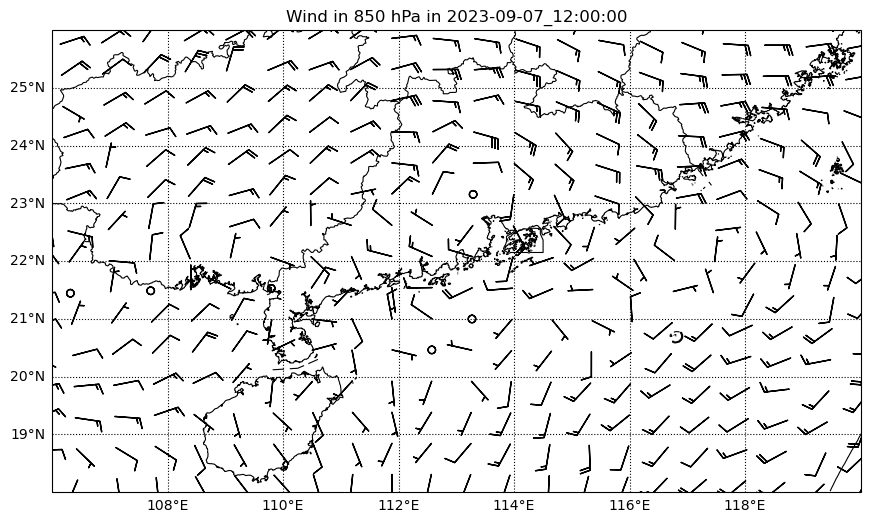

In [ ]:
ncfile = Dataset('/share/home/zhaokun/scratch/haiqin/exp/Haikui/3dvar_sfcrad/fc/2023090712/wrfinput_d02')

start_time = ncfile.getncattr('SIMULATION_START_DATE')
time = getvar(ncfile, "Times")
fcst_time = datetime.utcfromtimestamp(time.values.astype(int)* 1e-9)
time_str = fcst_time.strftime("%Y-%m-%d_%H:%M:%S")


slp = getvar(ncfile, "slp") # Sea Level Pressure
slp = slp.to_numpy()
# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 10, cenweight=2)


p = getvar(ncfile, "pressure")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
z = getvar(ncfile, "z", units="dm")

u_850 = interplevel(ua, p, 850)
v_850 = interplevel(va, p, 850)
ht_500 = interplevel(z, p, 500)
smooth_ht_500 = smooth2d(ht_500, 5, cenweight=2)
thin = [int(x/25.) for x in lons.shape]

fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=crs.PlateCarree())
ax.add_geometries(Reader(os.path.join(SHP, 'cnhimap.shp')).geometries(),
                      crs.PlateCarree(),facecolor='none',edgecolor='k', linewidth=0.8) 

#dbz_contours = ax.contour(to_np(lons), to_np(lats), to_np(smooth_ht_500),zorder=0,\
#                          levels = [586,588,590],\
#3                           #slp_levels = np.arange(960.,1020.,2.5),\
#            transform=crs.PlateCarree(), colors="k",)
#ax.clabel(dbz_contours,  inline=1, fontsize=10, fmt="%i")


ax.barbs(to_np(lons[::thin[0], ::thin[1]]), 
          to_np(lats[::thin[0], ::thin[1]]), 
          to_np(u_850[::thin[0], ::thin[1]]),
          to_np(v_850[::thin[0], ::thin[1]]), 
          length=6,transform=crs.PlateCarree())

ax.set_extent([106.,120.,18.,26.])


ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# Add the gridlines
gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = True
gl.xlocator = mticker.FixedLocator(np.arange(106,123,2))
#gl.ylocator = mticker.FixedLocator(yticks)

gl.y_inline = False # lat/lon doesn't show on the grid lines.
gl.x_inline = False

gl.xlabel_style  = {'rotation':'horizontal'}
plt.title("Wind in 850 hPa in "+ time_str)
plt.show()

In [3]:
def plt_prcp(ax, x, y, variable, cur_time = None, ini_time = None, \
           var_name = 'composite reflectivity (dBZ)', extent = [106.,122.,15.,26.], \
           var_levels = None, norm = None, var_map = None, isLeft = True, isBottom = True, sub_label = None):
    
    ax.add_geometries(Reader(os.path.join(SHP, 'cnhimap.shp')).geometries(),
                      crs.PlateCarree(),facecolor='none',edgecolor='k', linewidth=0.5) 

    sc = ax.scatter(x, y, c=variable, cmap=var_map, marker='o', transform=crs.PlateCarree(),  s=0.5, norm=norm,  edgecolors ='none') #,


    #ax.set_extent(extent,crs=crs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # Add the gridlines
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True if isBottom else False
    gl.left_labels = True if isLeft else False


    gl.xlocator = mticker.FixedLocator(np.arange(extent[0]+1,extent[1]+3,2))
    gl.ylocator = mticker.FixedLocator(np.arange(extent[2]+1,extent[3]+0.1,2))

    gl.y_inline = False # lat/lon doesn't show on the grid lines.
    gl.x_inline = False

    gl.xlabel_style  = {'rotation':'vertical', 'size':6}
    gl.ylabel_style  = {'rotation':'horizontal', 'size':6}

    ax.text(0.72, 0.03, 'max prcp. ' + str(np.max(variable)), horizontalalignment='center',
       verticalalignment='center', transform=ax.transAxes, fontsize=4)
    
    ax.text(0.05, 0.9, sub_label,  transform=ax.transAxes, fontsize=7, color='tab:red')
    return ax

In [4]:
def plt_rain(x, y, variable ,cur_time = None, ini_time = None, \
           extent = [107.,120.1,17.,26.],\
            var_levels = None, var_map = None, isLeft = True, isBottom = True, path = None):

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=crs.PlateCarree())

    ax.add_geometries(Reader(os.path.join(SHP, 'cnhimap.shp')).geometries(),
                        crs.PlateCarree(),facecolor='none',edgecolor='k', linewidth=0.7) 

    sc = ax.scatter(x, y, c=variable, cmap=prcp_map, marker='o', transform=crs.PlateCarree(), s=2, norm=prcp_norm)
    cb = fig.colorbar(sc, ax=ax, label='precipitation (mm/h)')
    cb.ax.tick_params(labelsize=8)
    ax.set_extent(extent,crs=crs.PlateCarree())

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # Add the gridlines
    gl = ax.gridlines(color="black", linestyle="dotted", draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.xlocator = mticker.FixedLocator(np.arange(106,123,2))
    #gl.ylocator = mticker.FixedLocator(yticks)
    gl.y_inline = False # lat/lon doesn't show on the grid lines.
    gl.x_inline = False
    gl.xlabel_style  = {'rotation':'horizontal'}
    #plt.text(0.72, 0.03, 'max precipitation: ' + str(np.max(variable)), horizontalalignment='center',
    # verticalalignment='center', transform=ax.transAxes, fontsize=12)
    plt.title("Accumulated precipitation  (mm/h) in " )
    if path is not None:
        plt.savefig(path, bbox_inches='tight', dpi=500)
    plt.show()
    #plt.close()
    return ax

In [5]:
wrfout_path = '/share/home/zhaokun/scratch/haiqin/exp/Haikui/3dvar_sfcrad/fc/2023090712/'
ncfile = Dataset(wrfout_path+'/wrfout_d02_2023-09-08_00:00:00')

In [6]:
levels = [0,0.1,10,25,50,100,250]

In [7]:
tc = getvar(ncfile, "tc")
wrf_lats, wrf_lons = latlon_coords(tc)
lats_wrf, lons_wrf = to_np(wrf_lats), to_np(wrf_lons)

In [8]:
print(lats[1]- lats_wrf[295, 248],lons_wrf[295, 248]-lons[1])

NameError: name 'lats' is not defined

In [ ]:
x_y = ll_to_xy(ncfile, lats, lons)
rain_station = []
rain_wrf = ncfile['RAINC'][0].data + ncfile['RAINNC'][0].data
for i, j in zip(x_y[:][0].data, x_y[:][1].data):
    rain_station.append(rain_wrf[j,i])
plt_rain(lons,lats,variable = rain_station,extend=extend)

NameError: name 'lats' is not defined

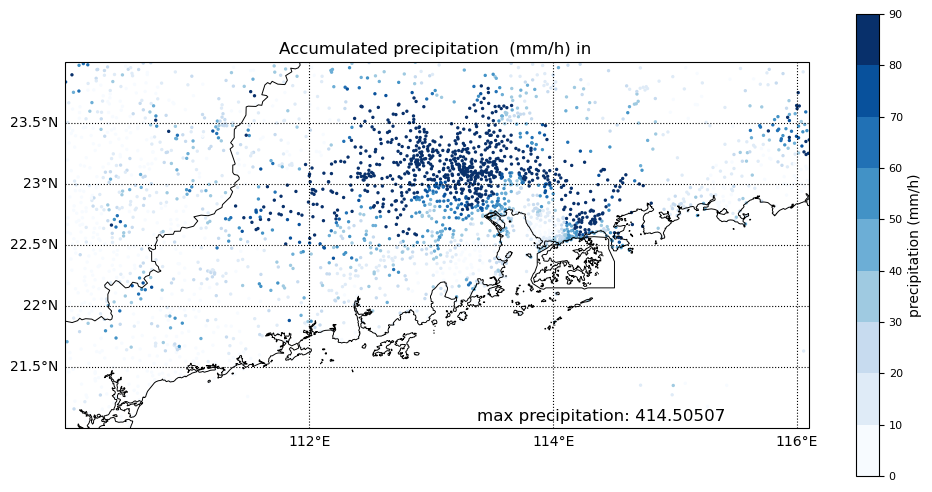

<GeoAxesSubplot: title={'center': 'Accumulated precipitation  (mm/h) in '}>

<class 'pandas.core.series.Series'>
wrfout_d02_2023-09-07_13:00:00


NameError: name 'ncfile' is not defined

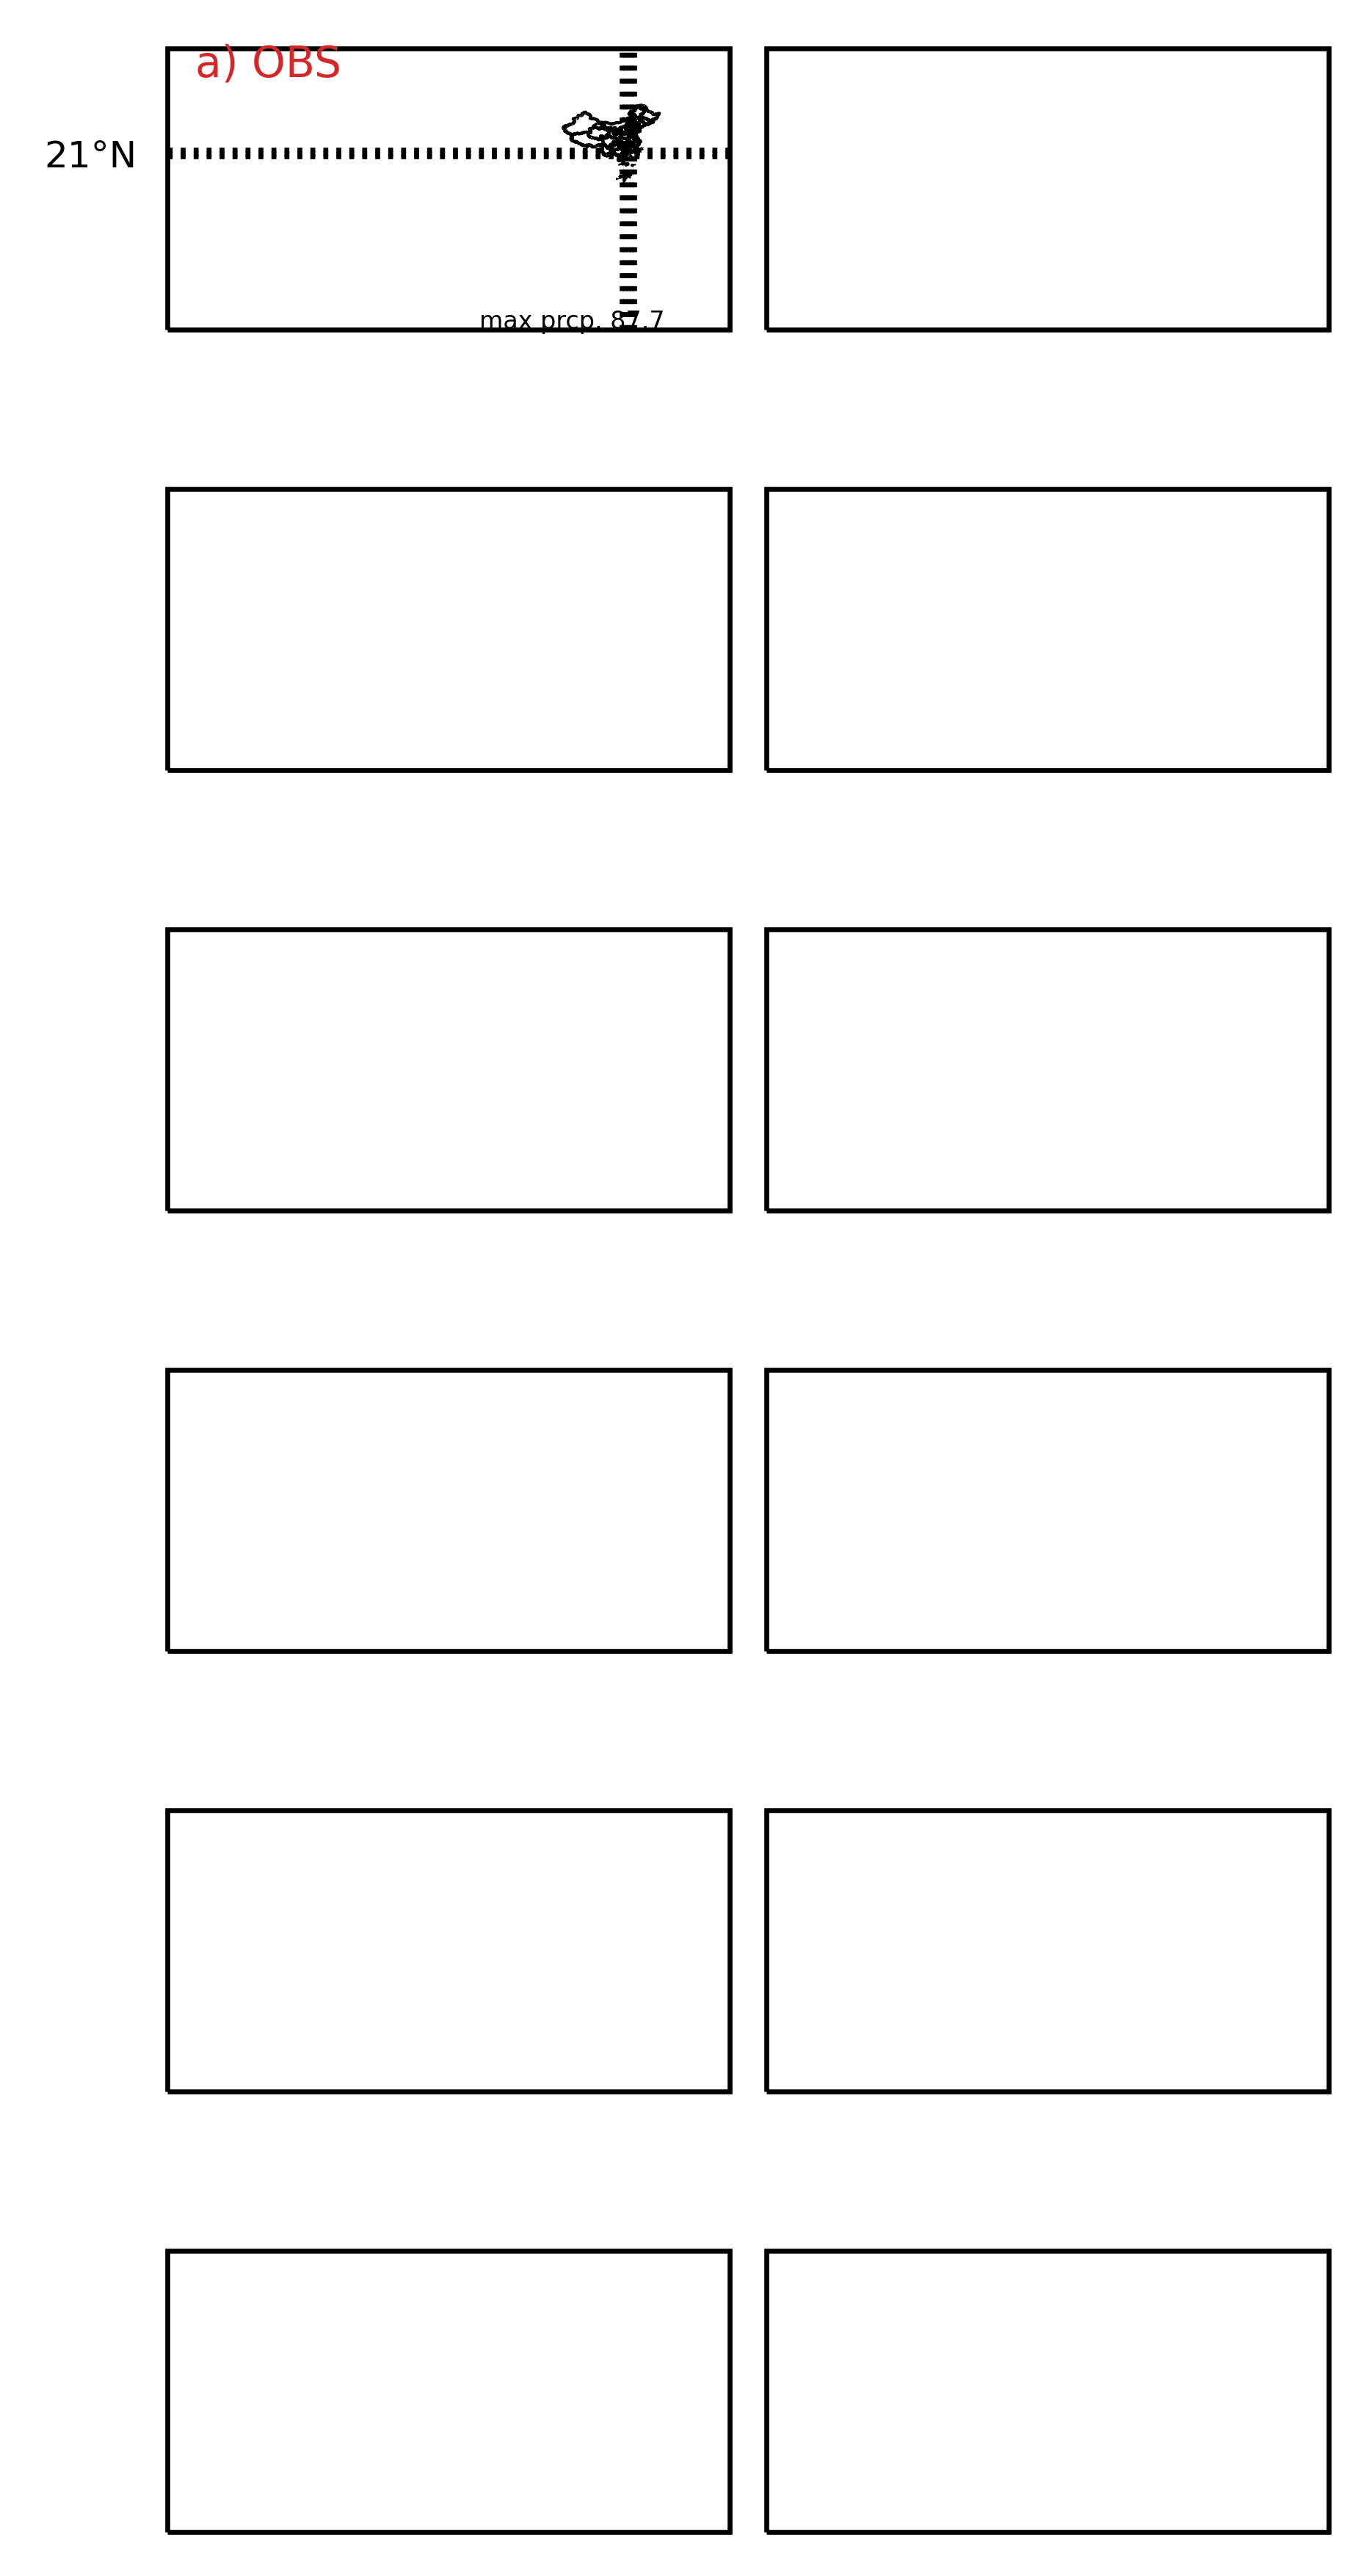

In [7]:
exp_names = ['OBS', '3dvar_conrad'] #, '3dvar_sfcrad', '3dvar_urban',  '3dvar_urban1']


path = '/share/home/zhaokun/haiqin/data/surf/'
cur_date = datetime(2023,9,7,12,0)
end_date = datetime(2023,9,7,12,0)
extent = [110.,118.0,20.,26.]

fcst_hrs = [0,1, 2,3,4,5]

acc_interval = 1 #if the 6h acc. prcp. is needed, set to 

OBS_dir = '/share/home/zhaokun/haiqin/data/surf/'
pathin = '/share/home/zhaokun/scratch/haiqin/exp/Haikui/'
pathout = '/share/home/zhaokun/haiqin/scripts/plot/saola_mdbz'

file_pattern = 'wrfout_d02_'

n_exp = len(exp_names)
n_times = len(fcst_hrs)

sub_labels = [chr(i) for i in range(97,97+n_times*n_exp)]

while cur_date <= end_date:

    

    fig, axes = plt.subplots(n_times,n_exp,figsize=(n_exp*1.5,n_times),dpi=600,
    sharey=True,sharex=True,
    constrained_layout=True,
    subplot_kw={'projection':crs.PlateCarree()})

    for i, fcst_hr in enumerate(fcst_hrs):
        for j, i_exp in enumerate(exp_names):
            cur_time = cur_date + timedelta(hours=int(fcst_hr))

            if i_exp == 'OBS':
                for i_hr in range(acc_interval):
                    i_time = cur_time + timedelta(hours=i)
                    file = os.path.join(OBS_dir,'SURF_'+i_time.strftime("%Y%m%d%H%M%S")+'.txt')
                    df = pd.read_csv(file, delim_whitespace=True, skiprows=1, header=0)

                    index = df[ (df['Lon']<= extent[0]) | (df['Lon']>= extent[1]) | (df['Lat']>= extent[3]) | (df['Lat']<= extent[2])].index
                    df.drop(index , inplace=True)
                    
                    df.set_index(['Station_Id_C','Lat','Lon'], inplace=True)
                    duplicate_index = df.index.duplicated()
                    df = df[~duplicate_index]
                    df['PRE_1h'] = df['PRE_1h'].replace(999999, np.nan)
                    if i_hr ==0:
                        df_acc = df[['PRE_1h']]
                    else:
                        acc2 = df[['PRE_1h']]
                        df_acc = df_acc.add(acc2,fill_value=0)   
                        print(i, df_acc['PRE_1h'].max(),  df['PRE_1h'].max(), len(acc2))
                        #prcp_column = "PRE_"+str(acc_interval)+'h'
                        #df_acc.rename(columns={"PRE_1h": prcp_column}, inplace=True)

                df_acc.reset_index(inplace=True)
                lats_sta = df_acc['Lat']
                lons_sta = df_acc['Lon']
                rain_station = df_acc["PRE_1h"]
                print(type(rain_station))
            else:
                wrfout_path = os.path.join(pathin,i_exp, 'fc', cur_date.strftime('%Y%m%d%H'))
                if not os.path.exists(wrfout_path): 
                    raise Exception("wrfout directory doesn't exist")
                ncfile_start = Dataset(wrfout_path+'/'+file_pattern+cur_time.strftime('%Y-%m-%d_%H:%M:%S'))
                acc_end_time  = cur_time + timedelta(hours=int(acc_interval))
                ncfile_end = Dataset(wrfout_path+'/'+file_pattern+acc_end_time.strftime('%Y-%m-%d_%H:%M:%S'))
                print(file_pattern+acc_end_time.strftime('%Y-%m-%d_%H:%M:%S'))
                if i == 0:
                    tc = getvar(ncfile_start, "tc")
                    wrf_lats, wrf_lons = latlon_coords(tc)
                lats, lons = to_np(wrf_lats), to_np(wrf_lons)
                x_y = ll_to_xy(ncfile, lats_sta, lons_sta)
                rain_station = []
                rain_wrf_start = ncfile_start['RAINC'][0].data + ncfile_start['RAINNC'][0].data
                rain_wrf_end = ncfile_end['RAINC'][0].data + ncfile_end['RAINNC'][0].data
                rain_wrf = rain_wrf_end - rain_wrf_start
                for ii, jj in zip(x_y[:][0].data, x_y[:][1].data):
                    rain_station.append(rain_wrf[jj,ii])
                print(type(rain_station))


            isLeft = True if j == 0 else False
            isBottom = True if i == (n_times - 1) else False
            sub_label = sub_labels[i*n_exp+j]+')'
            if i == 0:
                sub_label = sub_labels[i*n_exp+j]+') '+i_exp
            ax = plt_prcp(ax = axes[i,j],x =lons_sta, y = lats_sta, variable = rain_station, \
                    cur_time = cur_time.strftime('%Y%m%d%H%M'),  extent = extent, var_levels = prcp_levels, \
                    var_map = prcp_map, norm = prcp_norm,isLeft = isLeft, isBottom = isBottom, sub_label = sub_label)
            
    fc = fig.colorbar(
    mpl.cm.ScalarMappable(norm=prcp_norm, cmap=prcp_map),
    ax=axes,
    shrink=0.5,
    extendrect=False,
    orientation='vertical')
    fc.ax.tick_params(labelsize=8)
    
    fig.suptitle("accumulated precipitation initiated from "+ cur_date.strftime('%Y%m%d%H%M'), color='black', fontsize=8)
    plt.savefig(pathout+'/prcp_'+str(acc_interval)+'h_' + cur_date.strftime('%Y%m%d%H%M')+ '.png', bbox_inches='tight', dpi=200)
    plt.show()
    plt.close()

    cur_date += timedelta(hours=12)

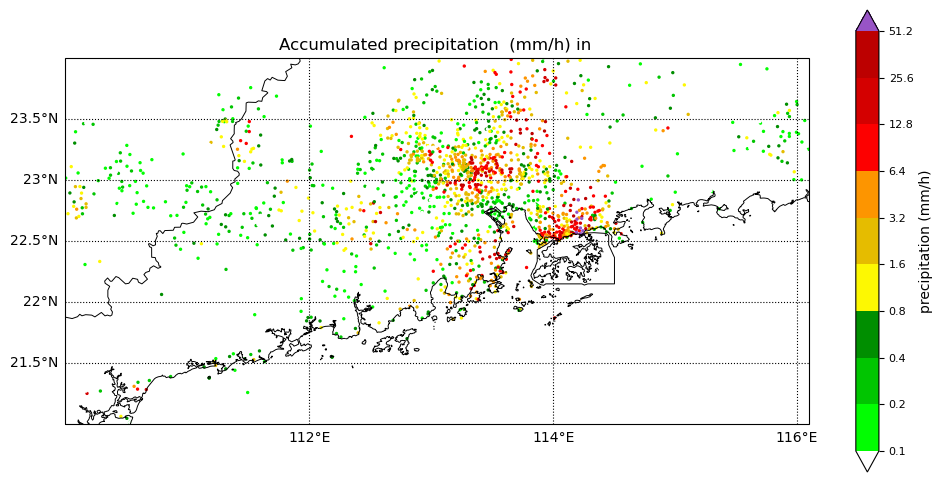

In [13]:
path = '/share/home/zhaokun/haiqin/data/surf/'
cur_time = datetime(2023,9,7,12)
time_end = datetime(2023,9,7,12)
fcst_hr = 1 #if the 6h acc. prcp. is needed, set to 6

while cur_time <= time_end:

    for i in range(fcst_hr):
        i_time = cur_time + timedelta(hours=i)
        file = os.path.join(path,'SURF_'+i_time.strftime("%Y%m%d%H%M%S")+'.txt')
        df = pd.read_csv(file, delim_whitespace=True, skiprows=1, header=0)

        index = df[ (df['Lon']<= extent[0]) | (df['Lon']>= extent[1]) | (df['Lat']>= extent[3]) | (df['Lat']<= extent[2])].index
        df.drop(index , inplace=True)
        
        df.set_index(['Station_Id_C','Lat','Lon'], inplace=True)
        duplicate_index = df.index.duplicated()
        df = df[~duplicate_index]
        df['PRE_1h'] = df['PRE_1h'].replace(999999, np.nan)
        
        if i ==0:
            df_acc = df[['PRE_1h']]
        else:
            acc2 = df[['PRE_1h']]
            df_acc = df_acc.add(acc2,fill_value=0)   
            print(i, df_acc['PRE_1h'].max(),  df['PRE_1h'].max(), len(acc2))

    df_acc.reset_index(inplace=True)
    lats = df_acc['Lat']
    lons = df_acc['Lon']
    ax = plt_rain(lons,lats,df_acc['PRE_1h'], cur_time=cur_time.strftime("%Y%m%d%H%M"),\
                  path = None, extent = [110.,116.1,21.,24.]) #'rain1h_'+cur_time.strftime("%Y%m%d%H%M")+'.png')
    
    cur_time += timedelta(hours=12)